In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from threading import Thread
import cv2
import os, sys
import time
import glob
from collections import defaultdict, namedtuple
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from itertools import chain, compress
from queue import Queue
from scipy.stats import chi2
import pytransform3d.transformations as pt
import pytransform3d.rotations as pr
from pytransform3d.plot_utils import make_3d_axis
from tqdm import tqdm

In [2]:
from config import *
from image_processing import *
from image_reader import *
from online_testing import *
from utils import *
from states import *
from feature import *

In [3]:
"""
Snapshot PnP VO solver
"""
class SnapshotPnPSolver(object):
    def __init__(self, config, verbose=True):
        self.config = config
        self.optimization_config = config.optimization_config
        self.map_server = dict()   # <FeatureID, Feature>
        self.state = None
        self.prev_state = CAMState()
        self.verbose = verbose

        self.K = self.to_K(config.cam0_intrinsics)
        self.T_cam_w = Isometry3d(config.T_cam0_imu[:3, :3], config.T_cam0_imu[:3, 3])

        CAMState.next_id = 0

        # Tracking rate.
        self.tracking_rate = None

        # Indicate if the received image is the first one. The system will 
        # start after receiving the first image.
        self.is_first_img = True

    def to_K(self, params):
        
        K = np.zeros((3,3))
        K[0, 0] = params[0]
        K[0, 2] = params[2]
        K[1, 1] = params[1]
        K[1, 2] = params[3]
        K[2, 2] = 1
        return K
    
    def feature_callback(self, feature_msg):
        """
        Callback function for feature measurements.
        """
        start = time.time()
        self.state = CAMState(CAMState.next_id)
        self.state.timestamp = feature_msg.timestamp
        
        t = time.time()

        # Add new observations for existing features or new features 
        # in the map server.
        self.add_feature_observations(feature_msg)

        if self.verbose:
            print('___add_feature_observations', time.time() - t)

        # Start the system if the first image is received.
        # The frame where the first image is received will be the origin.
        if self.is_first_img:
            self.is_first_img = False
            self.state.position = self.prev_state.position
            self.state.orientation = self.prev_state.orientation
        else:
            t = time.time()
            # Track state using visual odometry
            self.track_state(feature_msg)

            if self.verbose:
                print('___track_state', time.time() - t)
        if self.verbose:
            print('===snapshot PnP VO elapsed:          ', time.time() - start, f'({feature_msg.timestamp})')

        try:
            # Publish the odometry.
            return self.publish(feature_msg.timestamp)
        finally:
            # Reset the system if necessary.
            self.prev_state = self.state
            CAMState.next_id += 1

    def add_feature_observations(self, feature_msg):
        tracked_feature_num = 0
        curr_feature_num = len(self.map_server)
        for feature in feature_msg.features:
            if feature.id not in self.map_server:
                # This is a new feature.
                map_feature = Feature(feature.id, self.optimization_config)
                map_feature.observations[self.state.id] = np.array([
                    feature.u0, feature.v0])
                self.map_server[feature.id] = map_feature
            else:
                # This is an old feature.
                self.map_server[feature.id].observations[self.state.id] = np.array([
                    feature.u0, feature.v0])
                tracked_feature_num += 1

        self.tracking_rate = tracked_feature_num / (curr_feature_num+1e-5)

    def track_state(self, feature_msg):
        prev_id = self.prev_state.id
        curr_id = self.state.id

        prev_points = []
        curr_points = []
        for feature in feature_msg.features:
            map_feature = self.map_server[feature.id]
            if prev_id in map_feature.observations.keys():
                curr_points.append(map_feature.observations[curr_id])
                prev_points.append(map_feature.observations[prev_id])

        # print('Features for VO: ', list(zip(curr_points, prev_points)))

        prev_points = np.array(prev_points)
        curr_points = np.array(curr_points)

        # print('points shape ', prev_points.shape, curr_points.shape)

        R, T, _ = self.recover_pose(prev_points, curr_points)
        
        R_p_w = to_rotation(self.prev_state.orientation)
        T_p_w = self.prev_state.position

        H_p_w = Isometry3d(R_p_w, T_p_w)
#         H_c_p = Isometry3d(R, T)
#         print("Before ", R[:2, :2], T[:2])
        flip = np.array([
            [1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, 0.0, -1.0]
        ])
        H_c_p = Isometry3d(R, np.squeeze(T))
#         print("After")
#         print(T)
        # print("H_p_w ", H_p_w.R, H_p_w.t)
        # print("H_c_p ", H_c_p.R, H_c_p.t)

        H_c_w = H_p_w * H_c_p
        self.state.orientation = to_quaternion(H_c_w.R)
        self.state.position = H_c_w.t        

    def recover_pose(self, prev_points, curr_points, mask=None):
        E, mask = cv2.findEssentialMat(curr_points, prev_points, self.K, cv2.RANSAC, 0.9, 1.0, mask)
        
        _, R, T, mask = cv2.recoverPose(E, curr_points, prev_points, self.K, mask=mask)

        return R, T, mask
    
    def publish(self, time):
        state = self.state
        if self.verbose:
            print('+++publish:')
            print('   timestamp:', state.timestamp)
            print('   orientation:', state.orientation)
            print('   position:', state.position)
            print()
        
        H_c_w = Isometry3d(
            to_rotation(state.orientation),
            state.position)
        
        return namedtuple('vo_result', ['timestamp', 'pose'])(
            time, H_c_w)

In [4]:
class Trajectory(object):
    def __init__(self):
        self.times = []
        self.transforms = []
        self.max_s = np.zeros(3)
        self.min_s = np.zeros(3)
        
    def add_point(self, msg, origin="world"):
        if origin=="world":
            H_c_w = msg.pose
        elif origin=="cam":
            H_w_c = msg.pose
            H_c_w = H_w_c.inverse()
        self.times.append(msg.timestamp)
        self.transforms.append(H_c_w)
        t = H_c_w.t
        if len(self.times)==1 and (np.all(self.max_s==0) and np.all(self.min_s==0)):
            self.max_s = t.copy()
            self.min_s = t.copy()
        else:
            for j in range(3):
                self.max_s[j] = max(self.max_s[j], t[j]) 
                self.min_s[j] = min(self.min_s[j], t[j]) 
        
    def __len__(self):
        return len(self.times)

    def pytf_pose(self, num):
        r = self.transforms[num].R
        t = self.transforms[num].t
        r = pr.matrix_from_quaternion(pr.quaternion_from_matrix(r, strict_check=False))
        return r, t
    
    def create_plot(self, n=100000, mode="trajectory"):
        ax = make_3d_axis(ax_s=1, unit="m", n_ticks=6)

        scale = 1e-5 + max([i-j for i, j in zip(self.max_s, self.min_s)])/1.5
        center = [(i+j)/2.0 for i, j in zip(self.max_s, self.min_s)]

        ax.set_xlim((center[0]-scale, center[0]+scale))
        ax.set_ylim((center[1]-scale, center[1]+scale))
        ax.set_zlim((center[2]-scale, center[2]+scale))

        ax.view_init(azim=0, elev=90)
        
        last_n = min(len(self.times), n)
        t0 = self.transforms[0].t
        ax.scatter(t0[0], t0[1], t0[2], s=100, marker='o', color="lightgreen")
        tn = self.transforms[last_n-1].t
        ax.scatter(tn[0], tn[1], tn[2], s=100, marker='o', color="lightsalmon")
        if mode=="trajectory":
            t_x, t_y, t_z = [], [], []
            for num in tqdm(range(last_n)):
                t = self.transforms[num].t
                t_x.append(t[0])
                t_y.append(t[1])
                t_z.append(t[2])
            ax.scatter(t_x, t_y, t_z, s=0.1, color="gray")
        elif mode=="poses":
            for num in tqdm(range(last_n)):
                r, t = self.pytf_pose(num)
                pt.plot_transform(ax=ax, A2B=pt.transform_from(r, t))
        plt.tight_layout()

In [8]:
def ground_truth_load(times, file='/content/00.txt', start_idx=0):
    traj = Trajectory()
    with open(file) as f:
        lines = f.readlines()
        for i in tqdm(range(start_idx, min(len(times), len(lines)))):
            tmp44 = np.array(lines[i].rstrip().split(" ")[1:], dtype=np.float64).reshape((4, 4))
            H_curr = Isometry3d(tmp44[:3, :3], tmp44[:3, 3])
            timestamp = times[i]
            # print(timestamp, ' : ', H_curr)
            msg = namedtuple('ground_truth', ['timestamp', 'pose'])(
                    timestamp, H_curr)
            traj.add_point(msg, origin="world")
    return traj

In [17]:
# Pretty printing
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [39]:
# Paths
start_idx = 8017 - 5000
ids = sorted(glob.glob("/oak/stanford/groups/gracegao/KITTI360/KITTI-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect/*.png"))
ids = ids[start_idx:]
now = time.time()
timestamps = now + 0.03*np.arange(0, len(ids))
assert(len(ids) == len(timestamps))

In [40]:
cam0 = MonoCamera(ImageReader(ids, timestamps))
cam0.set_starttime(now)
img_queue = Queue()
img_publisher = DataPublisher(
        cam0, img_queue)

In [41]:
ip = ImageProcessor(ConfigKITTI360(), verbose=False)
solver = SnapshotPnPSolver(ConfigKITTI360(), verbose=False)
traj = Trajectory()

In [42]:
gt_traj = ground_truth_load(timestamps, file="/oak/stanford/groups/gracegao/KITTI360/data_poses/2013_05_28_drive_0000_sync/cam0_to_world.txt", start_idx=start_idx)
solver.prev_state.position = gt_traj.transforms[0].t
solver.prev_state.orientation = to_quaternion(gt_traj.transforms[0].R)
traj.max_s = gt_traj.max_s.copy()
traj.min_s = gt_traj.min_s.copy()

100%|██████████| 5484/5484 [00:00<00:00, 9055.71it/s]


100%|██████████| 5000/5000 [00:00<00:00, 600799.86it/s]


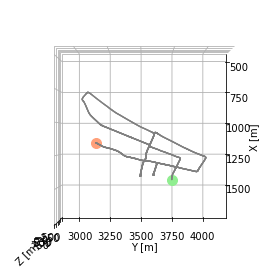

In [43]:
gt_traj.create_plot(n=5000)

In [44]:
img_publisher.start(now)

In [45]:
try:
    for i in tqdm(range(5000)):
        msg = img_queue.get()
        if msg is None:
            break
        meas = ip.camera_callback(msg)
        odom = solver.feature_callback(meas)
        traj.add_point(odom)
except Exception as e:
    print(e)
img_publisher.stop()

100%|██████████| 5000/5000 [03:00<00:00, 27.78it/s]


100%|██████████| 5000/5000 [00:00<00:00, 427196.84it/s]


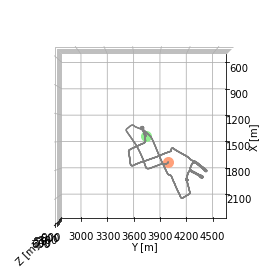

In [46]:
traj.create_plot()

100%|██████████| 1000/1000 [00:00<00:00, 497367.96it/s]


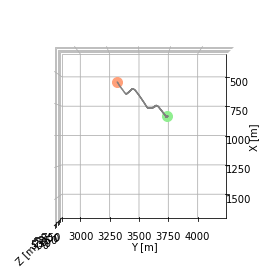

In [26]:
traj.create_plot()